# Plot census data using geopandas

In [10]:
%matplotlib inline

import geopandas as gpd
import pandas as pd

In [5]:
zip_f = "zip:////Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/tl_2020_36_tract.zip"

In [6]:
census_geo = gpd.read_file(zip_f)

In [37]:
census_geo.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,36,047,000700,36047000700,7,Census Tract 7,G5020,S,176774,0,+40.6923505,-073.9973434,"POLYGON ((-74.00154 40.69279, -74.00132 40.693..."
1,36,047,000900,36047000900,9,Census Tract 9,G5020,S,163469,0,+40.6917206,-073.9916018,"POLYGON ((-73.99405 40.69090, -73.99374 40.691..."
2,36,047,001100,36047001100,11,Census Tract 11,G5020,S,168507,0,+40.6932903,-073.9877087,"POLYGON ((-73.99073 40.69305, -73.99045 40.693..."


In [12]:
commute = pd.read_csv('nyc/ny_commute_census_tract.csv')
commute = commute.drop(0,axis=0)

In [31]:
commute = commute.rename(columns={"FIPS": "GEOID"})

In [34]:
combined = census_geo.merge(commute, on='GEOID')

In [38]:
combined.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,Workers 16 Years and Over: Did Not Work At Home,Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes,Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes,Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes,Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes,Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes,Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes,Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes,Workers 16 Years and Over: Worked At Home.1,Average Commute to Work (In Min)
0,36,047,000700,36047000700,7,Census Tract 7,G5020,S,176774,0,...,1884,132,165,316,632,481,39,119,303,36
1,36,047,000900,36047000900,9,Census Tract 9,G5020,S,163469,0,...,2627,181,565,494,751,545,25,66,613,29
2,36,047,001100,36047001100,11,Census Tract 11,G5020,S,168507,0,...,1039,30,222,191,297,196,47,56,151,32


<AxesSubplot:>

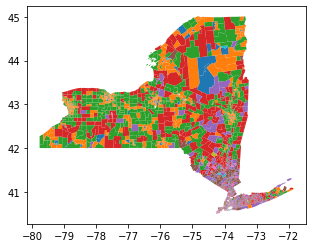

In [39]:
combined.plot(column = 'Average Commute to Work (In Min)')